In [31]:
import numpy as np

#from assets.keras.keras.datasets import shapes_3d
from assets.keras.keras.preprocessing.image import ImageDataGenerator
from assets.keras.keras.models import Sequential
from assets.keras.keras.layers.core import Dense, Dropout, Activation, Flatten
from assets.keras.keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D
from assets.keras.keras.optimizers import SGD, RMSprop
from assets.keras.keras.utils import np_utils, generic_utils
from assets.keras.keras.regularizers import l2
import theano
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

#load dataset from gen_dataset
import cPickle as pickle

In [62]:
import assets
print assets.keras.keras

import random



<module 'assets.keras.keras' from 'assets/keras/keras/__init__.py'>
[1, 2, 3, 4, 5, 7, 8, 9]


In [55]:
data = pickle.load(open('assets/data/lr_ds.data','rb'))



IOError: [Errno 2] No such file or directory: 'assets/data/lr_ds.data'

In [76]:
from assets.gen_motion import gen_dataset
import math
#gen_dataset(size, N, types, velocity, theta, coherence, dots)
X_train,Y_train,X_test,Y_test = gen_dataset((16,32,32),20,['translate'],[1],[0,math.pi],[0],[150])



print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', Y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', Y_test.shape

###
#X_train = X_train[0:200,:,:,:,:]
#Y_train = Y_train[0:200]
#X_val = X_val[0:40,:,:,:,:]
#Y_val = Y_val[0:40]
# convert class vectors to binary class matrices

Y_train/=math.pi
Y_test/=math.pi
Y_train = np_utils.to_categorical(Y_train[:,2]-1, 2)
Y_test = np_utils.to_categorical(Y_test[:,2]-1, 2)

Train data shape:  (36, 1, 16, 32, 32)
Train labels shape:  (36, 5)
Test data shape:  (4, 1, 16, 32, 32)
Test labels shape:  (4, 5)
[[ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]]


In [77]:

#(X_train, Y_train),(X_test, Y_test) = shapes_3d.load_data(test_split=test_split,
#                                                          dataset_size=dataset_size,
#                                                          patch_size=patch_size)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')



('X_train shape:', (36, 1, 16, 32, 32))
('Y_train shape:', (36, 2))
('X_test shape:', (4, 1, 16, 32, 32))
('Y_test shape:', (4, 2))
(36, 'train samples')
(4, 'test samples')


In [79]:

# CNN Training parameters
batch_size = 20
nb_classes = 2
nb_epoch = 500


# number of convolutional filters to use at each layer
nb_filters = [2,2,2]

# level of pooling to perform at each layer (POOL x POOL)
nb_pool = [2,2,2]

# level of convolution to perform at each layer (CONV x CONV)
nb_conv = [3,3,3]

# Regularization
reg = 1e-4

model = Sequential()
#model.add(ZeroPadding3D((1,1,1),))
model.add(Convolution3D(nb_filters[0],len_conv_dim1=nb_conv[0], len_conv_dim2=nb_conv[0], len_conv_dim3=nb_conv[0], border_mode='valid',
                         activation='relu', W_regularizer=l2(reg),dim_ordering='th',input_shape=(1,16,32,32)))
model.add(MaxPooling3D(pool_size=(1, nb_pool[0], nb_pool[0])))
#model.add(Dropout(0.5))
#model.add(ZeroPadding3D((1,1,1)))
model.add(Convolution3D(nb_filters[1],len_conv_dim1=nb_conv[1], len_conv_dim2=nb_conv[1], len_conv_dim3=nb_conv[1], border_mode='valid',
                        activation='relu', W_regularizer=l2(reg)))
#model.add(MaxPooling3D(pool_size=(nb_pool[1], nb_pool[1], nb_pool[1])))
#model.add(Dropout(0.5))
#model.add(ZeroPadding3D((1,1,1)))
model.add(Convolution3D(nb_filters[2],len_conv_dim1=nb_conv[1], len_conv_dim2=nb_conv[1], len_conv_dim3=nb_conv[1], border_mode='valid',
                        activation='relu', W_regularizer=l2(reg)))
model.add(Flatten())
#model.add(Dropout(0.5))
model.add(Dense(4, init='normal', activation='relu', W_regularizer=l2(reg)))
model.add(Dense(nb_classes, init='normal', W_regularizer=l2(reg)))
model.add(Activation('softmax'))

#Adam
sgd = RMSprop(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mse', optimizer=sgd)

hist = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch, show_accuracy=True, verbose=1,
          validation_split=.1)
scoretr = model.evaluate(X_train, Y_train, batch_size=batch_size, show_accuracy=True)
#scoreva = model.evaluate(X_val, Y_val, batch_size=batch_size, show_accuracy=True)
scorete = model.evaluate(X_test, Y_test, batch_size=batch_size, show_accuracy=True)
print('Train loss:', scoretr[0])
print('Train accuracy:', scoretr[1])
#print('Val loss:', scoreva[0])
#print('Val accuracy:', scoreva[1])
print('Test loss:', scorete[0])
print('Test accuracy:', scorete[1])

[autoreload of theano.gof.optdb failed: Traceback (most recent call last):
  File "/root/anaconda2/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name DefaultOrderedDict
]
[autoreload of theano.scan_module.scan failed: Traceback (most recent call last):
  File "/root/anaconda2/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name ifilter
]
[autoreload of theano.sandbox.rng_mrg failed: Traceback (most recent call last):
  File "/root/anaconda2/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ValueError: ('The name of the object cannot be an existing tag or the name of another existing object.', <theano.gof.opt.FromFunctionLocalOptimizer object at 0x7fd971a95b90>, 'local_gpua_mrg')
]
/root/anaconda2/lib

NameError: global name 'utils' is not defined

['acc', 'loss', 'val_acc', 'val_loss']


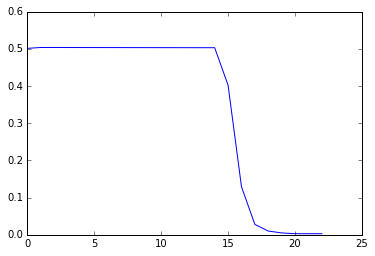

In [8]:
print model.history.history.keys()
plt.plot(np.asarray(model.history.history['loss'])[0:500])

In [9]:
for layer in model.layers:
    g = layer.get_config()
    h = layer.get_weights()
    print g
    for hi in h:
        print hi
        print hi.shape

{'len_conv_dim3': 3, 'W_constraint': None, 'b_constraint': None, 'name': 'Convolution3D', 'custom_name': 'convolution3d', 'len_conv_dim1': 3, 'activation': 'relu', 'trainable': True, 'init': 'glorot_uniform', 'input_shape': (1, 16, 32, 32), 'dim_ordering': 'th', 'cache_enabled': True, 'subsample': (1, 1, 1), 'nb_filter': 2, 'len_conv_dim2': 3, 'b_regularizer': None, 'W_regularizer': {'l2': 0.0001, 'name': 'WeightRegularizer', 'l1': 0.0}, 'activity_regularizer': None, 'border_mode': 'valid'}
[[[[[-0.20395908  0.1573754   0.0478937 ]
    [ 0.11195514  0.35108337 -0.41051653]
    [-0.0271833   0.00082663  0.06962187]]

   [[-0.26635227 -0.36103716 -0.24982116]
    [ 0.00582931 -0.19524644 -0.21682853]
    [-0.1480113   0.02863717 -0.38587698]]

   [[ 0.00352351  0.15339355  0.3793171 ]
    [-0.35264227  0.30549535 -0.0258821 ]
    [-0.28130206 -0.36101827 -0.29530063]]]]



 [[[[-0.36053416 -0.27856556 -0.05634708]
    [ 0.23180726  0.15361404 -0.35644373]
    [ 0.12395841  0.38511083 -0.

In [92]:
from keras.utils.visualize_util import plot
plot(model, to_file='model.png')

RuntimeError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.